# How to align with ultralytics yolov5

In [1]:
import os
import cv2

import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from yolort.models.yolo import YOLO
from yolort.utils import cv2_imshow, get_image_from_url, read_image_to_tensor
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords, attempt_download

## Prepare image and model weights to test

In [3]:
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_raw = get_image_from_url(img_source)

# yolov5s6.pt is downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt'
model_path = 'yolov5n6.pt'
checkpoint_path = attempt_download(model_path)

In [4]:
img_size = 640
stride = 64
score_thresh = 0.35
iou = 0.45

In [5]:
# Preprocess
image = letterbox(img_raw, new_shape=(img_size, img_size), stride=stride)[0]
image = read_image_to_tensor(image)
image = image.to(device)
image = image[None]

## Load model as ultralytics and inference

In [6]:
model_yolov5 = load_yolov5_model(checkpoint_path, autoshape=False, verbose=True)
model_yolov5 = model_yolov5.to(device)
model_yolov5.conf = score_thresh  # confidence threshold (0-1)
model_yolov5.iou = iou  # NMS IoU threshold (0-1)
model_yolov5 = model_yolov5.eval()


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [7]:
with torch.no_grad():
    ultralytics_dets = model_yolov5(image)[0]
    ultralytics_dets = non_max_suppression(ultralytics_dets, score_thresh, iou, agnostic=False)[0]

In [8]:
ultralytics_dets

tensor([[ 35.26947, 133.40977, 496.86469, 439.13141,   0.88235,   5.00000],
        [ 45.87330, 229.64430, 159.15872, 531.91492,   0.84495,   0.00000],
        [145.77780, 228.77318, 220.91098, 514.98694,   0.72589,   0.00000],
        [417.83066, 221.98871, 495.86893, 518.30176,   0.70359,   0.00000]], device='cuda:0')

## Updating model weights from ultralytics to yolort and inference

In [9]:
model_yolort = YOLO.load_from_yolov5(
    checkpoint_path,
    score_thresh=score_thresh,
    nms_thresh=iou,
    version="r6.0",
)

model_yolort = model_yolort.eval()
model_yolort = model_yolort.to(device)


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [10]:
with torch.no_grad():
    yolort_dets = model_yolort(image)

In [11]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[ 35.26947, 133.40977, 496.86469, 439.13141],
        [ 45.87330, 229.64430, 159.15872, 531.91492],
        [145.77780, 228.77318, 220.91098, 514.98694],
        [417.83066, 221.98871, 495.86893, 518.30176]], device='cuda:0')


In [12]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.88235, 0.84495, 0.72589, 0.70359], device='cuda:0')


In [13]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([5, 0, 0, 0], device='cuda:0')


## Verify the detection results between yolort and ultralytics

In [14]:
# Testing boxes
torch.testing.assert_allclose(yolort_dets[0]['boxes'], ultralytics_dets[:, :4])
# Testing scores
torch.testing.assert_allclose(yolort_dets[0]['scores'], ultralytics_dets[:, 4])
# Testing labels
torch.testing.assert_allclose(yolort_dets[0]['labels'], ultralytics_dets[:, 5].to(dtype=torch.int64))

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

In [15]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/notebooks/assets/coco.names"
label_path = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
from yolort.utils.image_utils import load_names
labels = load_names('./assets/coco.names')
```

Hah, that's the trick to rescale the box correctly

In [16]:
boxes = scale_coords(image.shape[2:], yolort_dets[0]['boxes'], img_raw.shape[:-1])
labels = yolort_dets[0]['labels']

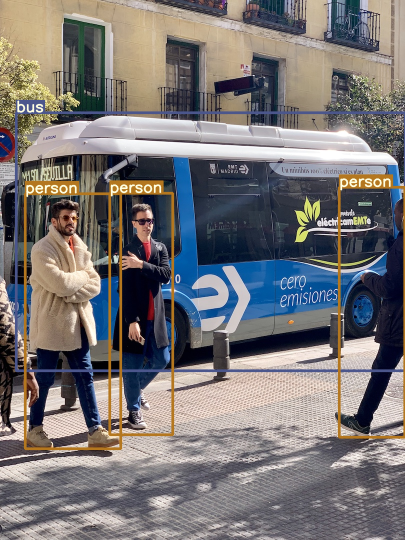

In [17]:
for box, label in zip(boxes.tolist(), labels.tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)